In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


urllib는 웹에서 데이터를 다운로드할 때 사용합니다.
cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요합니다.
pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리인데요. 아직 시맨틱 세그멘테이션 모델을 직접 만들기에는 어려우니 이번에는 준비된 모델을 사용만 해봅니다.

(288, 665, 3)


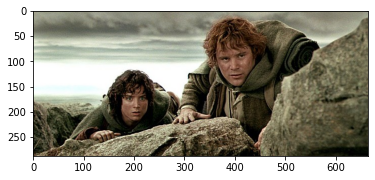

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ring.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7efef18777f0>)

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.



In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.

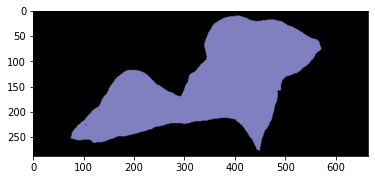

In [7]:
plt.imshow(output)
plt.show()

In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [9]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15] 

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [12]:
seg_color = (128,128,192)

(288, 665)


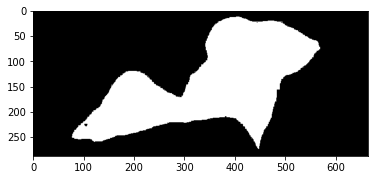

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

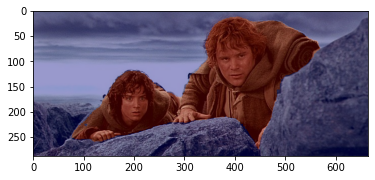

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

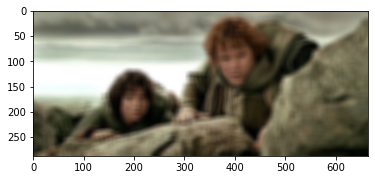

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

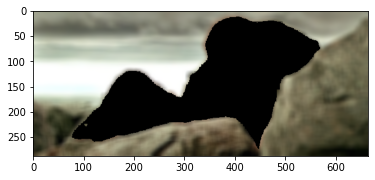

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.

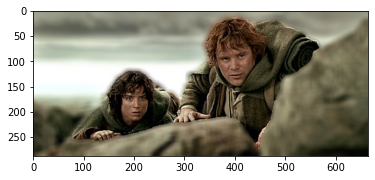

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

따라가기 끝
다른 클래스 같이 잡기

(427, 640, 3)


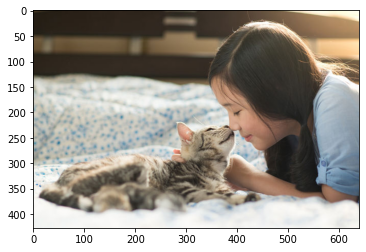

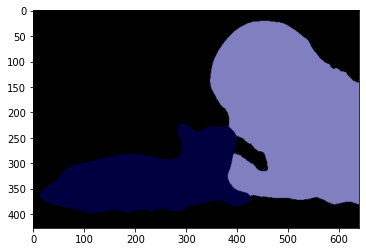

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_and_human.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()


고양이와 사람이 잡힌걸 볼수있다.

In [19]:
def check_class_id(segvalues) :
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id],class_id)
check_class_id(segvalues)

background 0
cat 8
person 15


In [20]:
def make_seg_color(class_num) :
    tmp = []
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    for num in class_num :
         tmp.append((colormap[num][1],colormap[num][2],colormap[num][0]))
    return tmp

seg_colors = make_seg_color([8,15])
print(seg_colors)

[(0, 0, 64), (128, 128, 192)]


(427, 640)


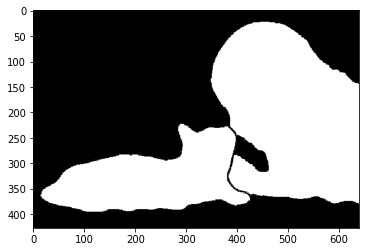

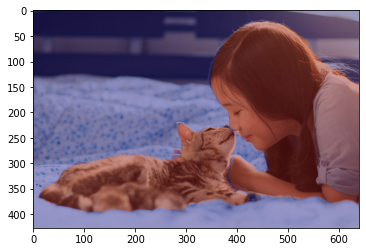

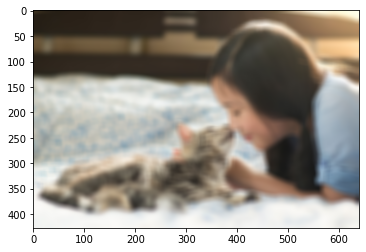

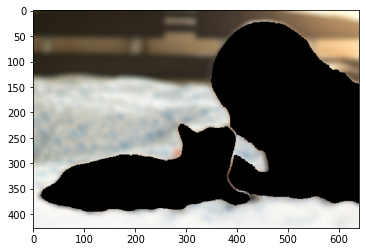

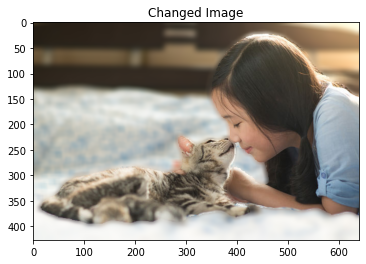

In [21]:
seg_map = np.all(((output==(128, 128, 192))|(output==(0, 0, 64))) , axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Changed Image')

#plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(1000, 1778, 3)


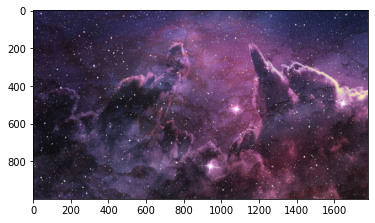

(427, 640, 3)


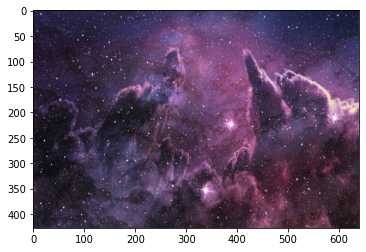

In [22]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/space.jpg'  
bg_img_orig = cv2.imread(bg_img_path) 
print(bg_img_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()
target_size = (img_orig.shape[1], img_orig.shape[0])
bg_resized = cv2.resize(bg_img_orig, target_size)
print(bg_resized.shape)
plt.imshow(cv2.cvtColor(bg_resized, cv2.COLOR_BGR2RGB))
plt.show()


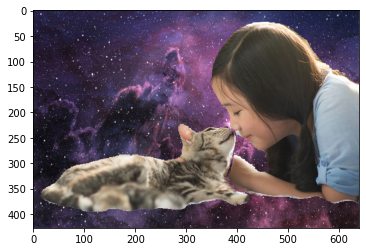

In [23]:
bg_img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
plt.imshow(cv2.cvtColor(bg_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점
![ex_screenshot](./prob1_1.PNG)
![ex_screenshot](./prob1.PNG)
![ex_screenshot](./prob2.PNG)

첫번째사진은 blur 배경과 세그멘테이션 한 객체가 약간 부자연스럽다.
두번째 사진은 배경을 바꾼것인데 더욱 잘 확인할 수 있다.
세번째 사진은 세그멘테이션 자체를 잘 못 하였다.


# Deeplib segmentation의 동작원리?

모델이 어떤식으로 segmentation하는지 내부적으로 알 수 없으니 데이터 전처리를 통해 segmentation이 바뀌는지 확인해보자

1. 배경을 blur한 이미지를 segmentation해보기
2. 전체적으로 blur한 이미지를 segmentation 해보기
3. edge detecting을 통해 sharping을 한 이후에 segmentation 해보기

(450, 800, 3)


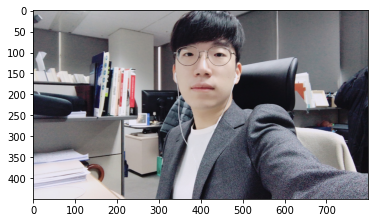

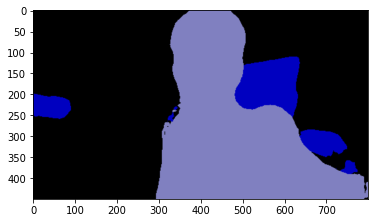

In [58]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ex_img.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

In [59]:
check_class_id(segvalues)

background 0
chair 9
person 15


In [60]:
seg_colors = make_seg_color([15])
print(seg_colors)

[(128, 128, 192)]


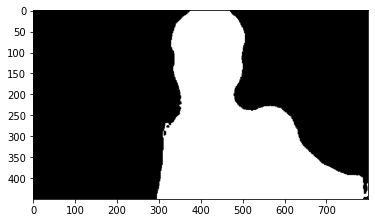

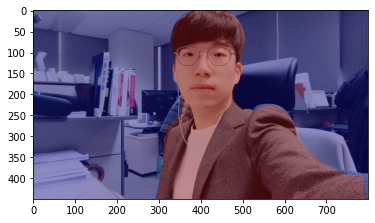

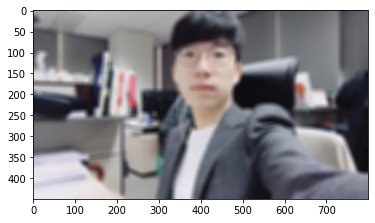

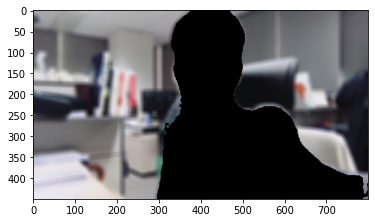

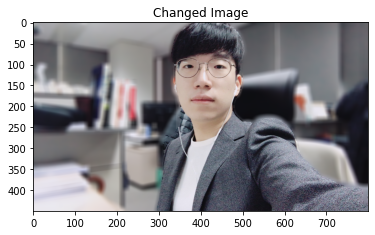

In [61]:
seg_map = np.all(output==(128, 128, 192) , axis=-1)
plt.imshow(seg_map, cmap='gray')
plt.show()
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Changed Image')

#plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


In [46]:
cv2.imwrite('changed_img.jpg', img_concat)

True

### 이 이미지를 segmentation 해보자

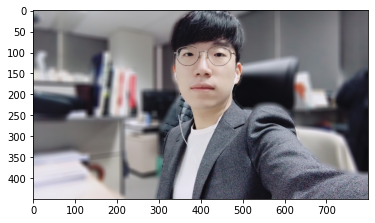

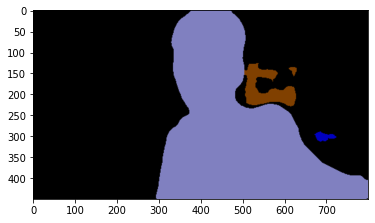

In [62]:
img_path = os.getenv('HOME')+'/aiffel/lap/changed_img.jpg'
img_orig = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

segvalues, output = model.segmentAsPascalvoc('./changed_img.jpg')
plt.imshow(output)
plt.show()

(450, 800)


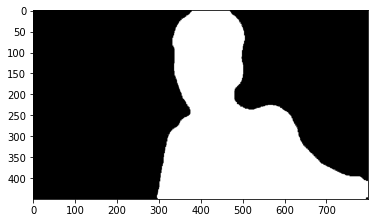

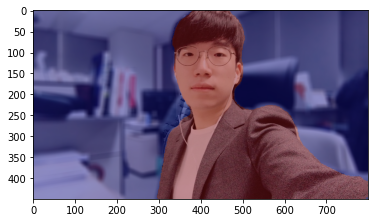

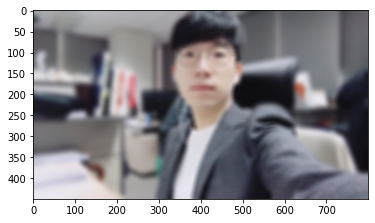

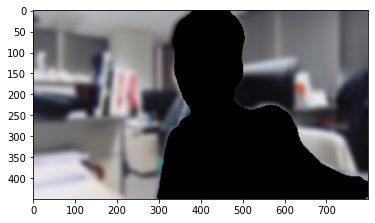

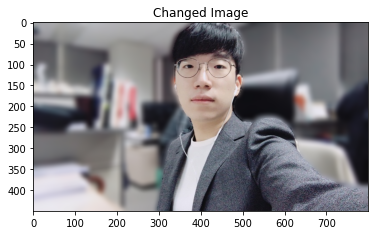

In [63]:
seg_map = np.all(output==(128, 128, 192) , axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Changed Image')

#plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

###  해결은 됐다. 아마 자켓의 끝자락과 뒤에 있는 패딩의 색이 유사해서 한 옷으로 취급하여 segmentation을 잘 하지 못한것으로 생각된다.

### 이제 세그멘테이션을 잘 했지만 약간 부자연스러운 사진에 전체적으로 blur를 먹여보자

(427, 640, 3)


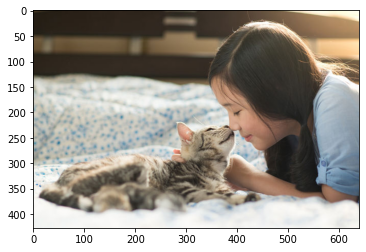

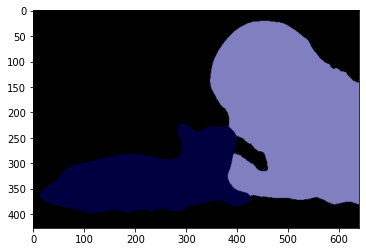

(427, 640)


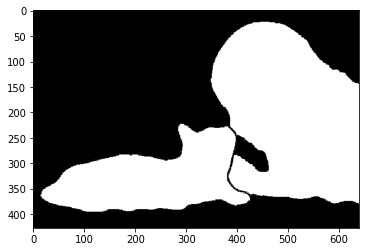

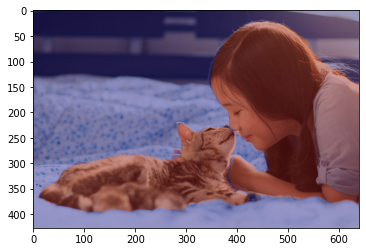

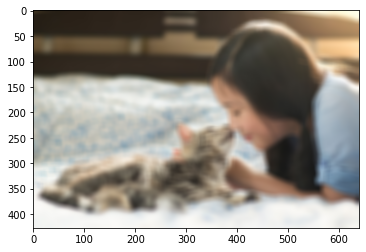

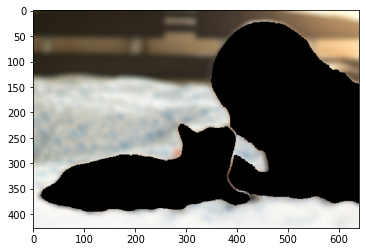

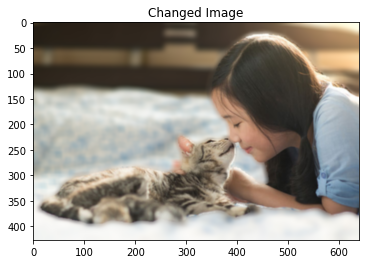

In [114]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_and_human.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()
seg_map = np.all(((output==(128, 128, 192))|(output==(0, 0, 64))) , axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_concat = cv2.blur(img_concat, (3,3))  
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Changed Image')

#plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 전체 이미지를 블러를 하니  부자연스러움이 사라졌다.
cv2.blur는 평균 블러링(Averaging Blurring) 커널을 만들어서 컨볼루션하는 번거로움을 줄이기 위해 OpenCV에서는 블러링하는 함수를 제공한다.
위의 이미지는 (3,3) 커널로 블러를 한것


In [67]:
edge = cv2.Laplacian(img_orig, -1)

In [68]:
# 결과 출력
merged = np.hstack((img_orig, edge))

Text(0.5, 1.0, 'Changed Image')

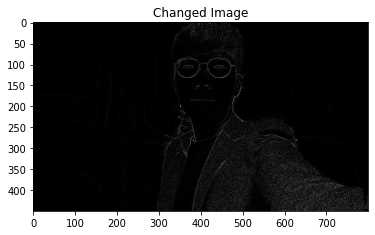

In [69]:
plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
plt.title('Changed Image')

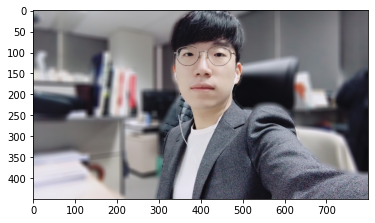

In [71]:
img_path = os.getenv('HOME')+'/aiffel/lap/changed_img.jpg'
img_orig = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


In [74]:
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
sharpening_out1 = cv2.filter2D(3, -1, sharpening_mask1) 
sharpening_out2 = cv2.filter2D(3, -1, sharpening_mask2)


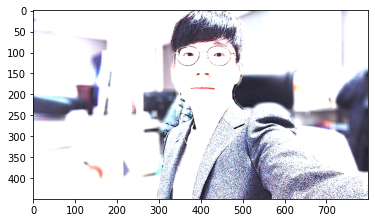

True

In [88]:
result =cv2.addWeighted(img_orig, 3.0, edge, -2.0, 0)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('result_img.jpg', result)

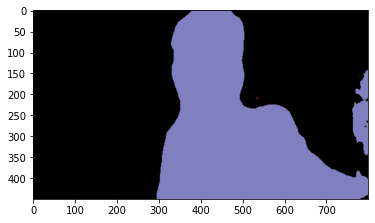

In [89]:
segvalues, output = model.segmentAsPascalvoc('./result_img.jpg')
plt.imshow(output)
plt.show()

(450, 800)


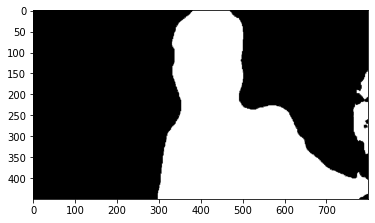

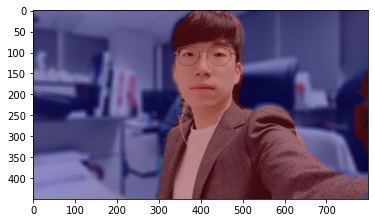

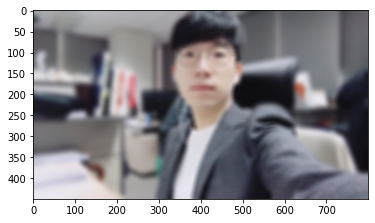

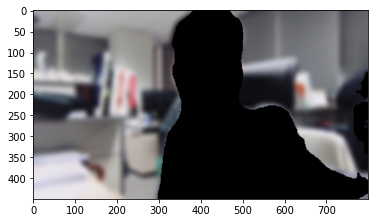

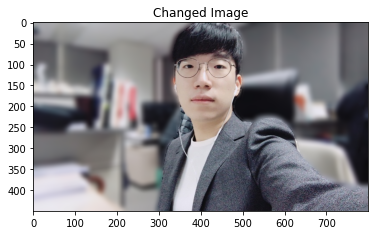

In [90]:
seg_map = np.all(output==(128, 128, 192) , axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Changed Image')

#plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### segmentation을 통해 사람빼고 blur  처리한 이미지를 라플라시안 필터를 통해 edge를 검출하고 addweight함수를 통해 샤프닝을 해보았다.

### 처음 마스킹 자체가 패딩과 뭉쳐져있어 딱히 변하는 부분은 없었는 것 같다.

# HOG 방법으로 생각해보기

우리는 HOG와 SVM을 합친 기법으로 이미지에서 얼굴영역을 확인하고 그 얼굴의 특징적인 부분을 landmark로 하여 스티커를 넣는 방식으로 Explonation을 진행한적 있다.

HOG는 대상 영역을 일정 크기의 셀로 분할하고, 각 셀마다 edge 픽셀(gradient magnitude가 일정 값 이상인 픽셀)들의 방향에 대한 히스토그램을 구한 후 이들 히스토그램 bin 값들을 일렬로 연결한 벡터이다. 즉, HOG는 edge의 방향 히스토그램 템플릿으로 볼 수 있다.

deep lib의 모델은 이미지의 edge의 방향에 영향을 많이 받는것인가, 아니면 rgb 전체 색상을 영향을 많이 받는 것인가 궁금해서 확인해보기로했다.

In [92]:
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

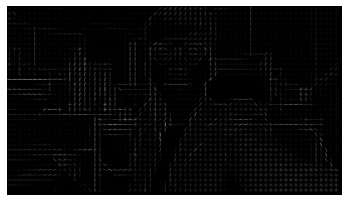

In [104]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ex_img.jpg'  
img_orig = cv2.imread(img_path)
img = img_orig.copy()
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(12, 12), cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

In [110]:

segvalues, output = model.segmentAsPascalvoc('./hog_img.jpg')
plt.imshow(output)
plt.show()


ValueError: not enough values to unpack (expected 3, got 2)

In [109]:
cv2.imwrite('hog_img.png', hog_image)
hog_image.shape

(450, 800)

# segmentation 은 channel이 1인 모델을 받지 않아서 아쉽게도 결과를 확인해보지는 못했다.

## 결론 
### 1. 분류할 객체와 다른 blur한 전체적인 이미지의 부 자연스러움은 한번 더 필터를 통해 blur하여 해결가능함
### 2. 분류할 객체의 마스킹을 잘 못 했을 경우 blur한 이미지를 다시 모델에 넣어 마스크를 찾는것도 하나의 방법이 될 수있을 것 같다.
### 3. 실제 바로 사진을 찍는 상황이라면  같은 위치에서 초점이 흐려지는 정도를 이용해 심도 계산을 하여 해결할 수 있을가 정도로 생각이 든다. 
이미지 전처리로 모델에 집어넣어 분류를 하는것은 모델 내부적인 동작을 잘 확인하기 어려워 힘들었다. 